# Keras MLP using SKLearn Pipeline on IRIS Dataset

## Iris dataset

In this notebook we're going to investigate highly renowned "Fisher's Iris" dataset for classifcation. This is a multi-class classification problem, meaning that there are more than two classes to be predicted, in fact there are three flower species. This is an important type of problem on which to practice with neural networks because the three class values require specialized handling.

## Load Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize

from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import SVG, display

C:\Users\cheru\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


set styles for plotting...


In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
seed = 123
np.random.seed(seed)

## Read IRIS Dataset

In [4]:
iris = load_iris()
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

Create pandas dataframe with objects in rows and features in columns

In [5]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Below there are the names of the classes for the further use.

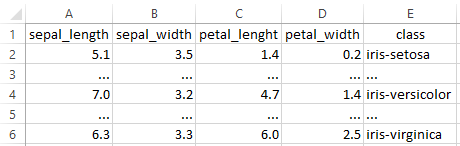

In [7]:
class_labels = ["setosa", "versicolour", "virginica"]

All the features here are continiuos numerical features

Let's also take a look into correlation matrix of features

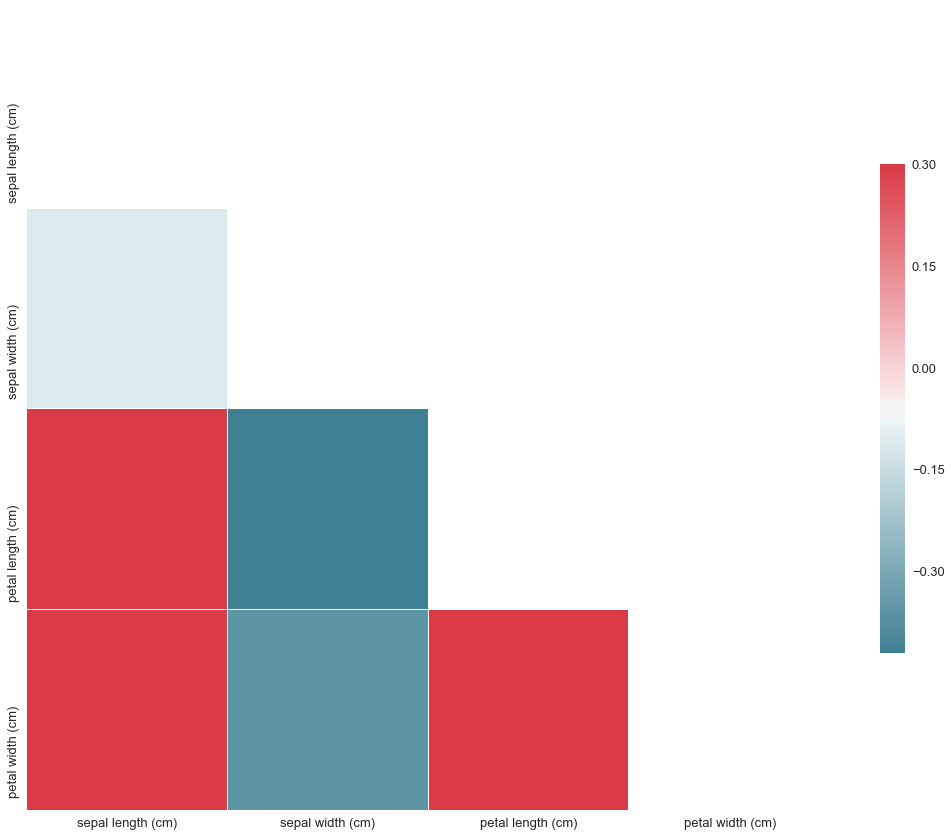

In [8]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Sometimes it's worth to take a look into paiwise features distributions. In some cases it becomes obvious how to separate classes and build a classifier

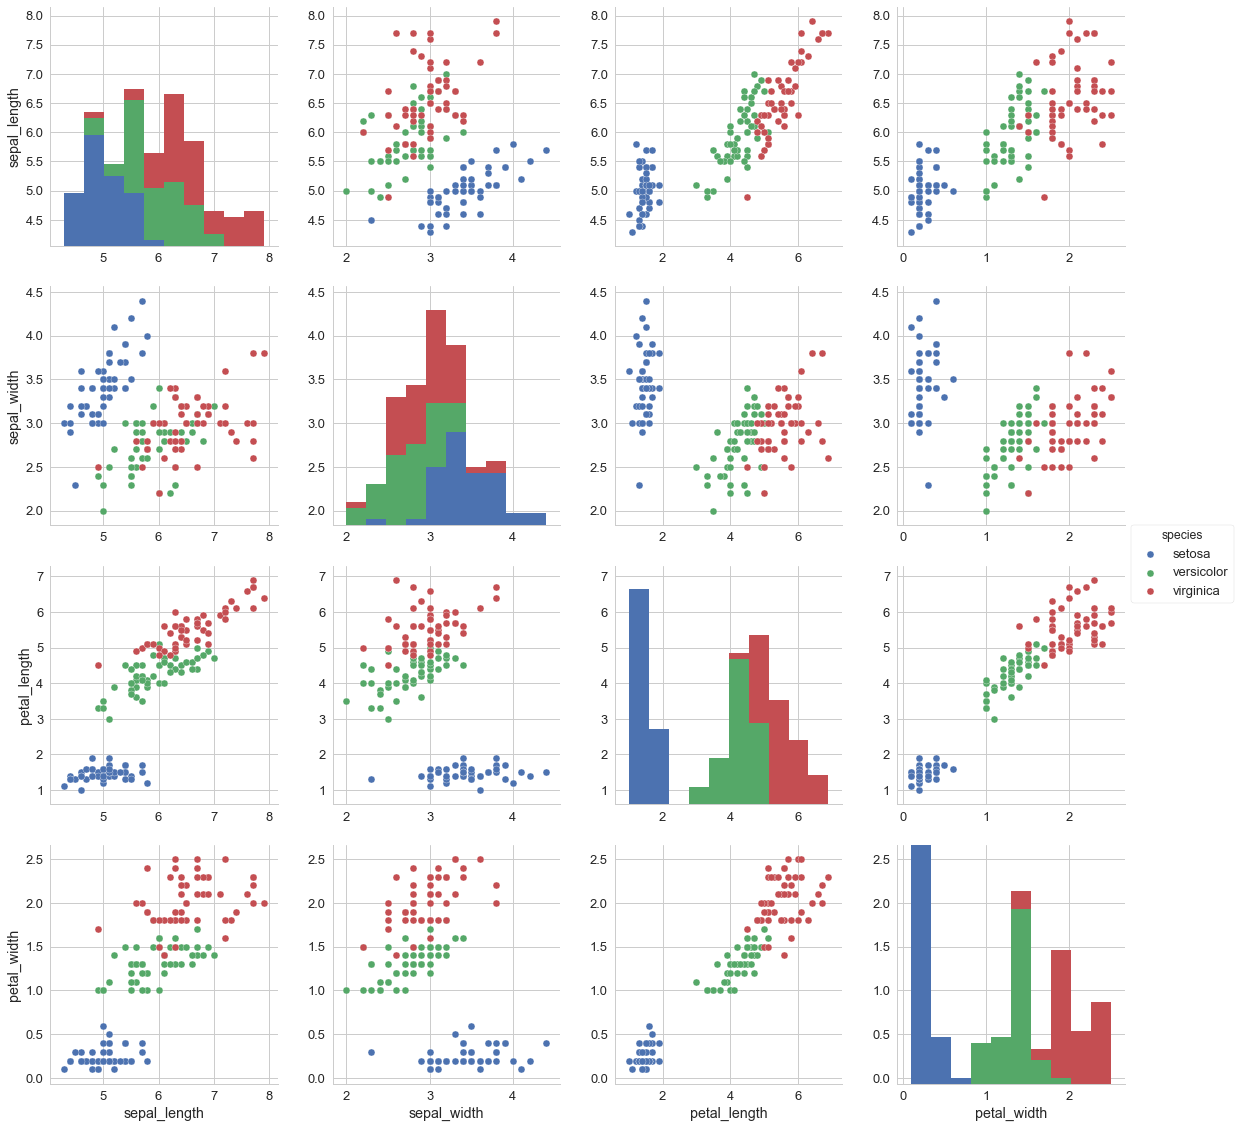

In [9]:
sns.pairplot(sns.load_dataset("iris"), hue="species", size=4);

As one can observe from this graph, one class (setosa) separates almost with no error. Other two are also almost linearly separable.

Therefore we anticipate very high classification quality.

## Data preprocessing
Here the scale of the features is almost the same for all the features thus there is no need to do rescaling. However, it is good practice to reshape the output attribute from a vector that contains values for each class value to be a matrix with a boolean for each class value and whether or not a given instance has that class value or not. 

This is called One-Hot encoding. For IRIS dataset, we will be expecting three class variables - Setosa, Versicolor and Virginica. We can turn this into one-hot encoded binary matrix for each class instance that would look as follows:


In [10]:
import pandas as pd
data = [[1,0,0], [0,1,0],[0,0,1]]
pd.DataFrame(data, columns=["Setosa", "Versicolor", "Virginica"])
 

,Setosa,Versicolor,Virginica
0,1,0,0
1,0,1,0
2,0,0,1


We will use LabelEncoder to achieve one-hot encoding

In [12]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)


## Multilayer Perceptron (MLP)

Multilayer perceptron is a multi-layer feedforward network. Feedforward networks often have one or more hidden layers of
sigmoid neurons followed by an output layer of linear neurons. Multiple layers of neurons with nonlinear transfer functions allow the network to learn nonlinear and linear relationships between input and output vectors. The linear output layer lets the network produce values outside the range -1 to +1. 

As soon as the architecture and the performance of multilayer perceptron are determined by the number of hidden layers and by
the number of neurons in each hidden layer these are the network design parameters that are adjusted. The correct classification
function is introduced as the ratio of number of correctly classified inputs to the whole number of inputs. 

Multilayer perceptrons with 1 and 2 hidden layers are investigated. The procedure of adjusting the number of neurons is done using cross validation. With each combination of numbers of neurons in the hidden layers the multilayer perceptron is trained on the train set, the value of correct classification function for the train set is stored. The validation set is used for standard early stopping procedure, the value of correct classification function for the validation set is stored as well. The values of the correct classification function are plotted versus the corresponding number of neurons in the hidden layer. 

Referece: http://lab.fs.uni-lj.si/lasin/wp/IMIT_files/neural/doc/seminar8.pdf


We will use KerasClassifier class in Keras as an estimator.

Below is a function that will create a baseline neural network for the iris classification problem. It creates a simple fully connected network with one hidden layer that contains 8 neurons.

The hidden layer uses a rectifier activation function which is a good practice. Because we used a one-hot encoding for our iris dataset, the output layer must create 3 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

The network topology of this simple one-layer neural network can be summarized as: 4(inputs)-8(hidden nodes)-3(outputs).

Note that we use a “softmax” activation function in the output layer. This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.

Finally, the network uses the efficient Adam gradient descent optimization algorithm with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.

Iris dataset has 4 features per sample. Thus we have 4 units in the input layer. Our problem has 3 classes and therefore we should have 3 output units.

Input nodes/neurons: 4 (sepal length, sepal width, petal length, petal width)

Output nodes/neurons: 3 (setosa, versicolor, virginica)

Given only there are 4 input variables, we will not need PCA (dimensionality reduction here).

## Define Neural Network Model

In [13]:
# define baseline model
def create_model(neurons=1):   
    # create model
    model = Sequential()
    #relu - rectified linear unit
    model.add(Dense(neurons, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


We can also pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() function internally used to train the neural network. Here, we pass the number of epochs as 200 and batch size as 5 to use when training the model. Debugging is also turned off when training by setting verbose to 0.

In [14]:
estimator = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)

## Evaluate the model using Grid Search Cross Validation

### Tune the number of neurons in the hidden layer

The number of neurons in a layer is an important parameter to tune. Generally the number of neurons in a layer controls the representational capacity of the network, at least at that point in the topology.

Let us use Grid Search to tune the number of neurons in the hidden layer.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.

Ref: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

**For IRIS Dataset, we will look at tuning the number of neurons in a single hidden layer. We will try values from 3 to 12 in steps of 3.**

First we can define the model evaluation procedure. Here, we set the number of folds to be 10 (an excellent default) and to shuffle the data before partitioning it. We will use the optimized number of neurons in the hidden layer of the neural network.

In [ ]:
# define the grid search parameters
neurons = [3, 6, 9, 12]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, dummy_y)

Summarize the results

In [15]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.000000 using {'hidden_neurons': 3}
0.000000 (0.000000) with: {'hidden_neurons': 3}
0.000000 (0.000000) with: {'hidden_neurons': 6}
0.000000 (0.000000) with: {'hidden_neurons': 9}
0.000000 (0.000000) with: {'hidden_neurons': 12}


We can see that the best results were achieved with a network with 9 neurons in the hidden layer with an accuracy of about 98%.